In [17]:
import typing
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_auc_score, f1_score

from tqdm import tqdm

from scipy.stats import ks_2samp

from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.pipeline import Pipeline

import xgboost as xgb


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import NullFormatter
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv("Downloads/train (1).csv")

In [8]:
df.head(2)

feature-0  feature-1  feature-2  feature-3   feature-4   feature-5  \
0  37.977273   6.758452   3.636364  10.792929  160.801682  151.109783   
1  19.408163   5.933978   2.816327   5.877551  162.949911   76.153796   

   feature-6  feature-7  feature-8  feature-9 ...   feature-1515  \
0   1.791689   6.818675   8.138413   8.270161 ...       5.658393   
1   1.381401   6.002651   5.080499   7.514421 ...       4.830811   

   feature-1516  feature-1517  feature-1518  feature-1519  feature-1520  \
0      4.151040      4.540632      4.953183      5.351562      5.311048   
1      3.817712      4.123094      4.426343      4.823804      4.652173   

   feature-1521  feature-1522  feature-1523    y  
0      5.560922      5.643015      5.715999  0.0  
1      4.795274      4.860781      5.001426  0.0  

[2 rows x 1525 columns]

In [9]:
X = df.iloc[:,:-1]
y = df.y

In [13]:
y.value_counts()

1.0    790
0.0    315
Name: y, dtype: int64

Классы несбалансированы, но не критично, однако, все же будем использовать AUC ROC, как устойчивую метрику для несбалансированных классов

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=55)

Посмотрим корреляцию фич:

In [12]:
corr_matrix = X.corr()

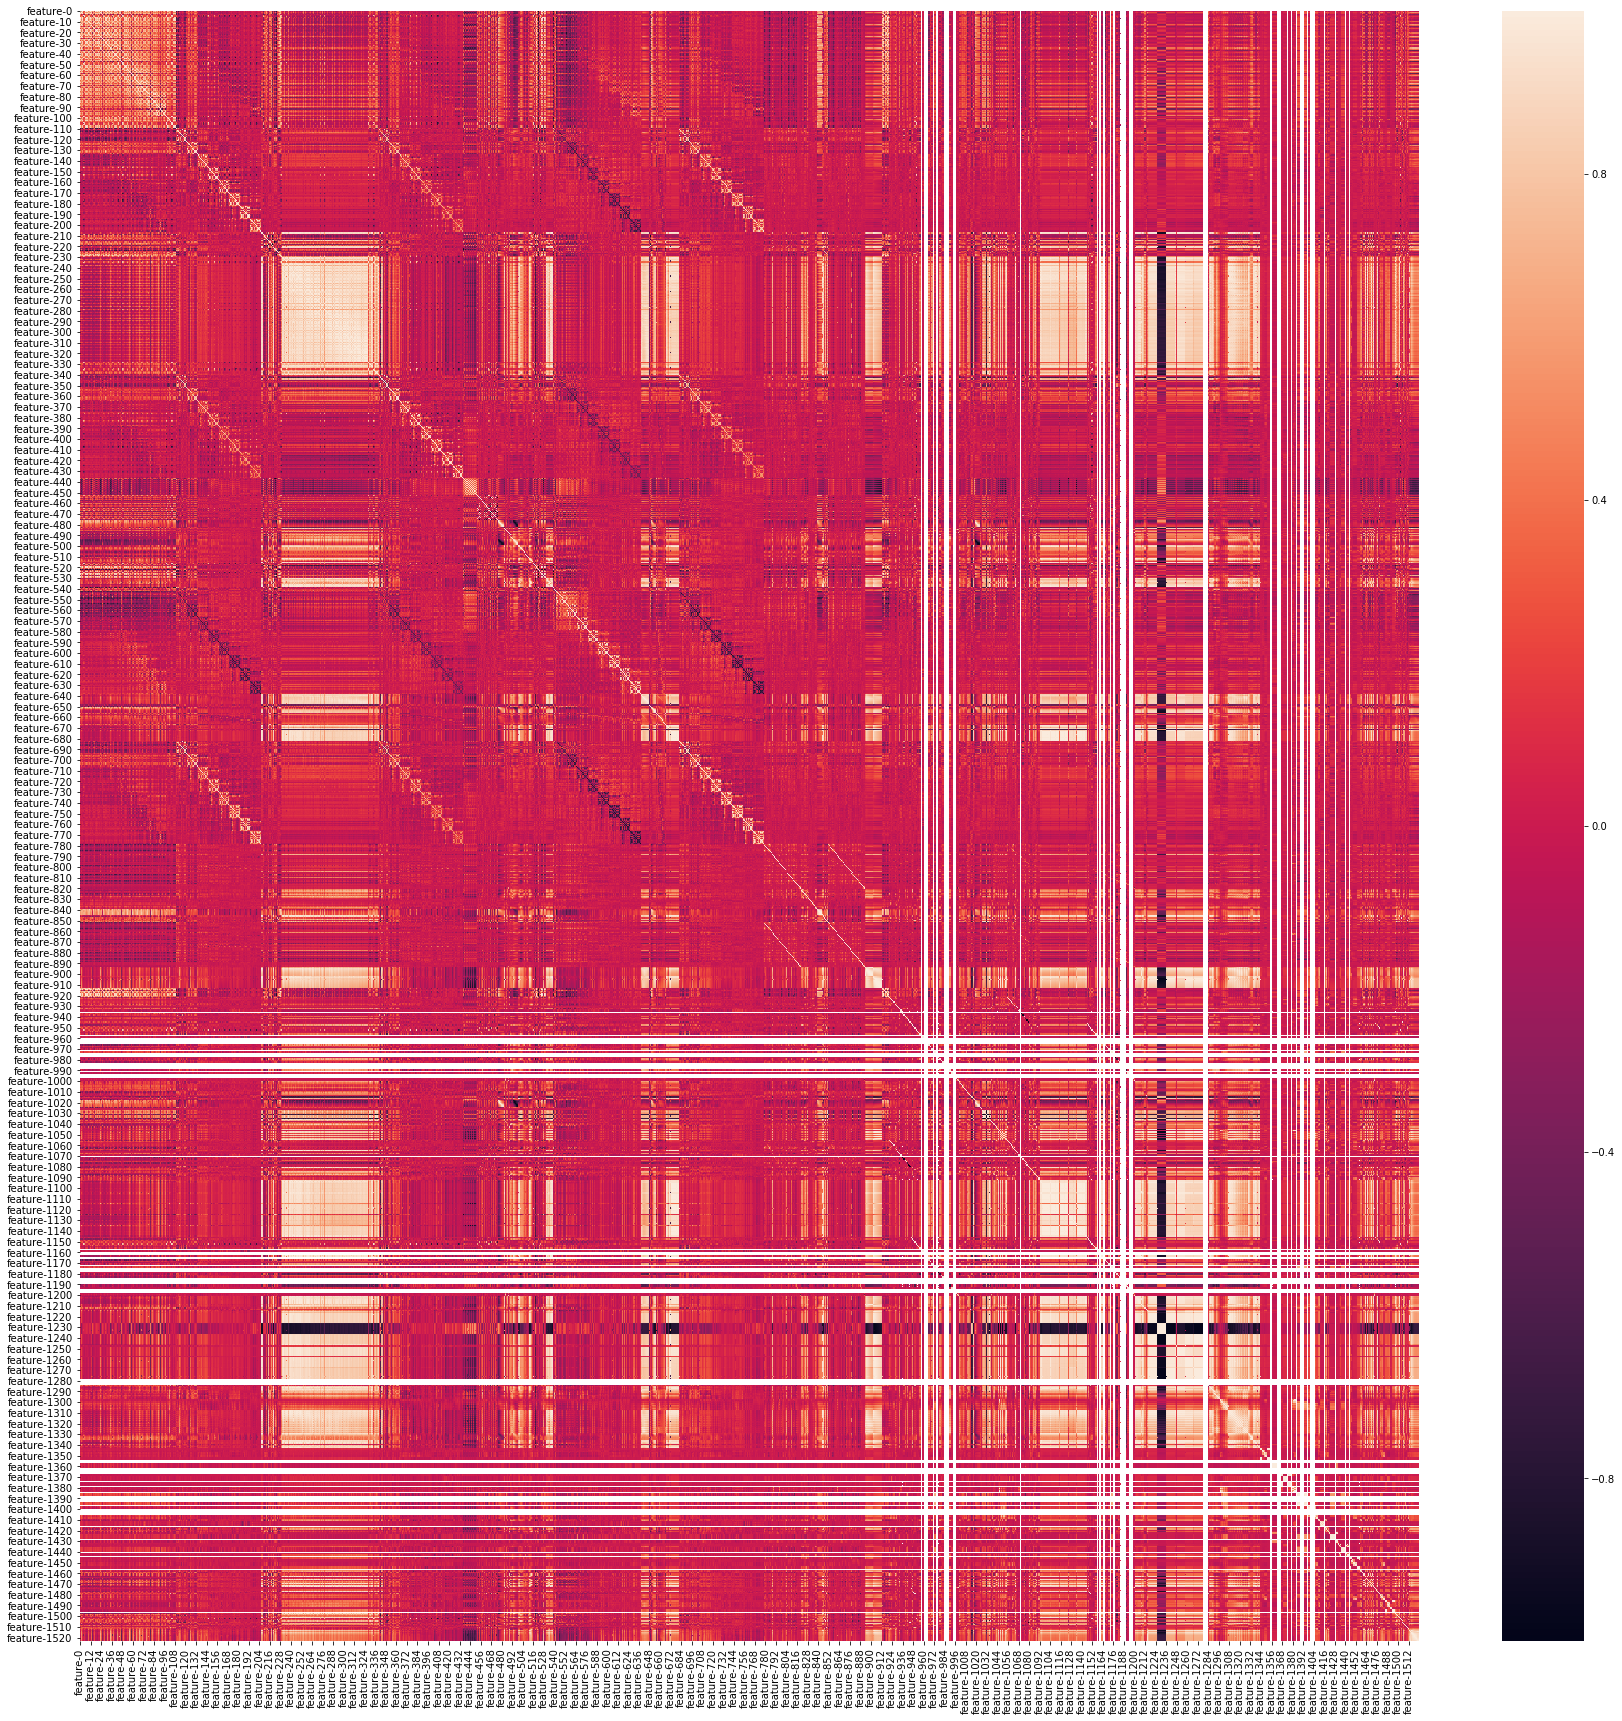

In [15]:
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(corr_matrix, ax=ax)

На этом замечательном графике видим довольно много фич, которые коррелируют друг с другом. Возьмем это на заметку, т.к., например, в "деревянных" моделях это может принести нам очень много проблем, тем более на таком маленьком датасете

Выбросим коррелирующие фичи

In [18]:
def high_correlation(df: pd.DataFrame, threshold: float) -> typing.List[str]:
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    return [column for column in upper.columns if any(upper[column] > threshold)]

In [19]:
to_drop = high_correlation(X, threshold=0.95)

In [20]:
len(to_drop)

664

In [21]:
X_clean = X.drop(to_drop, axis=1)

In [22]:
X_clean.shape

(1105, 860)

### Посмотрим линейные модели:

In [35]:
linear_clf = LogisticRegression(penalty='l1')
linear_clf.fit(X_train, y_train)
print(classification_report(y_test, linear_clf.predict(X_test)))

             precision    recall  f1-score   support

        0.0       0.66      0.66      0.66        61
        1.0       0.87      0.87      0.87       160

avg / total       0.81      0.81      0.81       221



Посмотрим на кросс-валлидации:

In [26]:
def CV_tests(X: pd.DataFrame, y: pd.Series, model):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_ids, valid_ids in cv.split(X):
        model.fit(X.loc[train_ids], y.loc[train_ids])
        y_pred_valid = model.predict(X.loc[valid_ids])
        auc_roc = roc_auc_score(y_pred_valid, y.loc[valid_ids])
        print(f'valid aur_roc: {auc_roc:.5f}')

Посмотрим как работает модель на "чистых" данных и на исходных, как влияет удаление сильно коррелирующих фич

In [31]:
CV_tests(X, y, model=LogisticRegression(penalty='l1'))

valid aur_roc: 0.78526
valid aur_roc: 0.78186
valid aur_roc: 0.78323
valid aur_roc: 0.84826
valid aur_roc: 0.78191


Пахнет нестабильностью

Проверим на данных с удаленными фичами на тех же фолдах

In [34]:
CV_tests(X_clean, y, model=LogisticRegression(penalty='l1'))

valid aur_roc: 0.76449
valid aur_roc: 0.77161
valid aur_roc: 0.82022
valid aur_roc: 0.84933
valid aur_roc: 0.77663


Качество просело, окей, пока что будем работать со всеми данными

Подберем гиперпараметры:

In [37]:
def check_lasso(C, X_tr, y_tr, X_te, y_te, c_w):
    lr_lasso = LogisticRegression('l1', C = C, class_weight=c_w)
    lr_lasso.fit(X_tr, y_tr)
    lasso_pred = lr_lasso.predict_proba(X_te)
    return roc_auc_score(y_te, lasso_pred[:,1]), (lr_lasso.coef_ != 0).sum(), lr_lasso

In [38]:
from sklearn.grid_search import GridSearchCV

In [44]:
clf_ = LogisticRegression(penalty='l1')
Cs = np.logspace(-2, 1, 10, base=10)
clf = GridSearchCV(clf_,
            dict(C=Cs),
                 cv=2,
                 pre_dispatch='1*n_jobs',
                 n_jobs=2)

clf.fit(X, y)


GridSearchCV(cv=2, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'C': array([ 0.01   ,  0.02154,  0.04642,  0.1    ,  0.21544,  0.46416,
        1.     ,  2.15443,  4.64159, 10.     ])},
       pre_dispatch='1*n_jobs', refit=True, scoring=None, verbose=0)

In [49]:
clf.grid_scores_

[mean: 0.83891, std: 0.00920, params: {'C': 0.01},
 mean: 0.83982, std: 0.01553, params: {'C': 0.021544346900318832},
 mean: 0.83439, std: 0.00648, params: {'C': 0.046415888336127774},
 mean: 0.82805, std: 0.00740, params: {'C': 0.1},
 mean: 0.81991, std: 0.01555, params: {'C': 0.21544346900318834},
 mean: 0.80905, std: 0.01918, params: {'C': 0.46415888336127775},
 mean: 0.80362, std: 0.01918, params: {'C': 1.0},
 mean: 0.82353, std: 0.00106, params: {'C': 2.154434690031882},
 mean: 0.81176, std: 0.01103, params: {'C': 4.6415888336127775},
 mean: 0.82534, std: 0.00106, params: {'C': 10.0}]

Нет времени на пересчеты и графики, пусть будет так у Lasso регуляризации

зафиксирую random_state для переносимости

### Дервеянные модели

Попробуем потбирать фичи с помощью RandomForest и xgboost, по идее на маленьких деревях результаты должны получаться хорошими, однако тот факт, что фичи коррелируют между собой может сбивать их с толку 

возьмем неглубоких деревьев и посадим их

In [182]:
clf_rf = RandomForestClassifier(n_estimators=30, max_depth=4, class_weight='balanced', random_state=22)
clf_xgb = xgb.XGBClassifier(n_estimators=40)

In [141]:
def show_stat_train(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    print(classification_report(y_test, prediction))
    print(f"ROC-AUC is {roc_auc_score(y_test, prediction)})")

In [186]:
show_stat_train(clf_rf, X_train, y_train, X_test, y_test)

             precision    recall  f1-score   support

        0.0       0.66      0.67      0.67        61
        1.0       0.87      0.87      0.87       160

avg / total       0.82      0.81      0.81       221

ROC-AUC is 0.7704405737704918)


Деревянные модели логично проседают по классу "0" по полноте очень сильно, связано с сильной корреляцией, можем попробовать хитрость проверить:
На том же рандом сиде проверим как ведет себя модель на чистых данных

In [116]:
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean,y, test_size=0.2, random_state=55)

In [143]:
show_stat_train(clf_rf, X_train_clean, y_train_clean, X_test_clean, y_test_clean)

             precision    recall  f1-score   support

        0.0       0.72      0.72      0.72        61
        1.0       0.89      0.89      0.89       160

avg / total       0.85      0.85      0.85       221

ROC-AUC is 0.8075307377049181)


In [145]:
show_stat_train(clf_xgb,X_train_clean, y_train_clean, X_test_clean, y_test_clean)

             precision    recall  f1-score   support

        0.0       0.81      0.69      0.74        61
        1.0       0.89      0.94      0.91       160

avg / total       0.87      0.87      0.87       221

ROC-AUC is 0.8130122950819673)


In [183]:
show_stat_train(clf_xgb,X_train, y_train, X_test, y_test)

             precision    recall  f1-score   support

        0.0       0.81      0.69      0.74        61
        1.0       0.89      0.94      0.91       160

avg / total       0.87      0.87      0.87       221

ROC-AUC is 0.8130122950819673)


**НО:** Несколько раз запускал, кажется, что модель все равно переобучается на разных фолдах и при разных сидах, проблема не решена

Потюним рандом форест

In [102]:
def evaluate_param(clf, parameter, num_range, index):
    grid_search = GridSearchCV(clf, scoring='roc_auc', param_grid = {parameter: num_range})
    grid_search.fit(X, y)
    print(grid_search.best_estimator_)
    
    df = {}
    for i, score in enumerate(grid_search.grid_scores_):
        df[score[0][parameter]] = score[1]
       
    
    df = pd.DataFrame.from_dict(df, orient='index')
    df.reset_index(level=0, inplace=True)
    df = df.sort_values(by='index')
 
    plt.subplot(3,2,index)
    plot = plt.plot(df['index'], df[0])
    plt.title(parameter)
    return plot, df

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=4, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=61, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=9, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


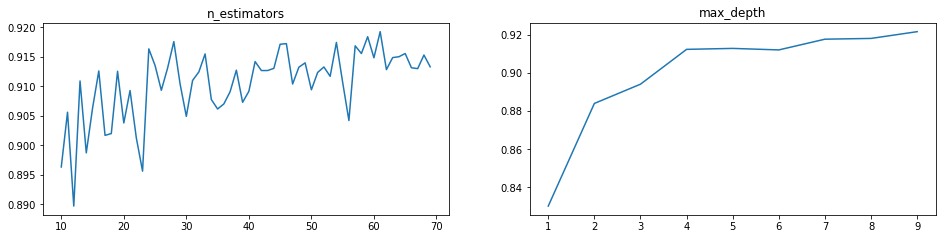

In [103]:
param_grid = {"n_estimators": np.arange(10, 70, 1),
              "max_depth": np.arange(1, 10, 1)}

index = 1
plt.figure(figsize=(16,12))
for parameter, param_range in dict.items(param_grid):   
    evaluate_param(clf_rf, parameter, param_range, index)
    index += 1

Однако заберу хорошие веса фич

In [187]:
rf_w = clf_rf.feature_importances_

xgb_w = clf_xgb.feature_importances_

In [198]:
np.argsort(xgb_w)[::-1][:100]

array([1460,  982, 1025,  369,   63,  226, 1521,   49,  463,   96,  857,
        545,  643,  687,  624,  338,  660, 1085, 1286,  741,  834, 1418,
        659,  473,  458,  706,  685,  224,  511,  360,  320,  508,  495,
       1332,  528,  886,  658,  849, 1520, 1191,   17,   55,   62,   64,
         81,  598,   92,   94,  566, 1045,  600,  106,  555, 1004,  666,
        588,  686,  623, 1523,  767,  698,  702, 1088, 1086, 1055, 1024,
       1014, 1013,  968,  881,  878,  841,  823,  803,  784,  577,  765,
        763,  753,  733,  723,  719,  710,  584,  502,  572,  568,  214,
        191,  187,  176,  173,  160,  152,  149,  140,  134,  132,  130,
        114])

Момент истины -- сравним топ-10 фич:

In [188]:
len(set(np.argsort(rf_w)[::-1][:10]) & set(np.argsort(xgb_w)[::-1][:10]))


2

Но вот с топ-50 ситуация не такая радостная:

In [189]:
len(set(np.argsort(rf_w)[::-1][:50]) & set(np.argsort(xgb_w)[::-1][:50]))


9

Да и вообще чет совсем все плохо

Нужно более тщательно и ресурсоемко заниматься тюнингом гиперпараметров, развернуть hyperopt, подумать над борьбой с переобучением и с грязными данными

#### Небольшой conclusion этой недоделки

Что хотелось сделать:

* Попробовать разные линейные модели для отбора фич
* Попробовать модели на основе деревьев, т.к. они очень хорошо должны отбирать фичи, на Каггле по-крайней мере они очень сильно выручают
* Убрать сильно коррелирующие фичи -- пробовал, не получил желаемого результата
* Засунуть все в PCA -- не зашло сходу, т.к. не смог на глаз быстро подобрать оптимальное кол-во компонент, поэтому отложил
* Возможно попробовать прогнать через автоэнкодер
* Проверка статистических критериев